# Classification Neural Network without TensorFlow or Keras

Author: Robin Girardin

Date : 31.12.2024

## Table of Content
1. [Presentation of the project](#presentation-of-the-project)

2. [Forward Propagation](#forward-propagation)

      2.1. [Linear Transformation](#linear-transformation)

      2.2. [Activation Function](#activation-function)

      2.3. [Weight Matrix](#weight-matrix)

      2.4. [Input Matrix](#input-matrix)

      2.5. [Bias Vector](#bias-vector)

      2.6. [Computation](#computation)

      2.6.1. [Linear Transformation](#linear-transformation)

      2.6.2. [Activation Function](#activation-function)

      2.7. [ReLU](#relu)

      2.8. [Softmax](#softmax)

      2.9. [Forward pass](#forward-pass)

3. [Backward Propagation](#backward-propagation)

      3.1.[Weight updating](#weight-updating)

      3.2. [Bias updating](#bias-updating)

4. [Prediction](#prediction)

      4.1. [Training Performance](#training-performance)

      4.2. [Testing Performance](#testing-performance)

## Presentation of the project
As of late, I've been exploring Machine Learning algorithms. It's time for me to learn more about Deep Learning and Neural Networks.
I've been learning the math behind those concept and here is my attempt to build a simple Neural Network without the help of any library, except for numpy and pandas.
The purpose of this project is to built a solid fundation for future deep learning projects. How can one become an expert at something without building it from scratch? I'll attempt to explain my thought process throughout the project.
The code will be naturally supported by mathematic formulas, so that the reader can judge my understanding of the topic. Beware that I'm no mathematician.
Therefore, please excuse me if my notation isn't conform to the norms. I still hope it will be understandable.

For this, I'll attempt to code a neural network for a supervised multiclass classification task.
The goal is to make the model able to classify numbers from 1 to 9 from the famous
[MNIST dataset](#https://www.kaggle.com/datasets/oddrationale/mnist-in-csv?select=mnist_train.csv).

Since each image of the MNIST dataset is composed of 784 pixels, the input layer of our new model will have 784 nodes.
Additionnaly, we expecting a classification between 10 numbers (0 included), consequently, the output layer of our new model will have 10 nodes.
Finally, we need to define how much nodes and layers our model's hidden layers will have.
Since I want to have a small model at first, I'll go for a single hidden layer with 10 nodes.

> After finishing the model and training it, there was some overflow issue. I strandardized the data `X_train_stand` and `X_test_stand` to solve this issue.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train = np.array(pd.read_csv("../data/raw/mnist_train.csv"))
test = np.array(pd.read_csv("../data/raw/mnist_test.csv"))

X_train = np.delete(train, 0, axis=1)
Y_train = train[:, 0]

X_train_stand = X_train * (1 / 255)

X_test = np.delete(test, 0, axis=1)
Y_test = test[:, 0]

X_test_stand = X_test * (1 / 255)

## Forward Propagation
Forward propagation is the computation of the linear transformation multiplied by the activation function, which is commonly called the hypothesis function.
It is composed of two processes : the linear transformation $Z$ and the activation function $\sigma\left(Z\right)$.


### Linear Transformation
As you can see, the result of the $Z$ is passed down to the activation function.
The purpose of the linear transformation is to adjust the input recieved by the previous layer using two important parameter, called weights $W$ and biases $B$.
Each feature (in our case a single pixel) $x_{m, n}$ of each example (the whole image composed of  784 pixels :
$x$ ($\begin{bmatrix} x_{1, 1} & x_{1, 2} & \dots & \ x_{1, 784} \end{bmatrix}$) fed to the model will be adjusted by its own corresponding weight $w_{i, j}$.
This allow a neuron to downplay or increase the importance of specific features $x_{m, n}$ of the example so that its output is a specific combination of the example's features.
The linear transformation function can module the importance of each feature only linearly.

This output acts as a new feature, which will be fed to further layers to create new, more complex, features following the same process.
$Z$ acts as a decision boundary separating part of the original data, thus creating a new feature.
$$
Z(X) = WX + B
$$
Where:
* $W$: Weight matrix for the layer.
* $X$: Input matrix or to the layer.
* $b$: Bias vector for the layer.


### Activation Function
Due to the linear nature of the pre-activation function $Z$, multiple issues arise.
Firstly, the modulation of feature importance is limited and cannot explain more complex interactions in the data.
For example, let's say a particular feature created by a neuron have a increasingly lower impact on the final output the higher its values are.
In order to represent this, you would need to make sure that values outputed by the neuron are capped to a limit, right?
This would limit the impact of of said value, aka feature, on the final model.

Secondly, since $Z = W * X + B$ acts as a decision boundary which separates new features, it being linear is inherently limiting.
What if, in order to separate a group of points, a "S" shapes curve is more appropriate?

Thirdly, each neuron outputs a value, which is fed to other neurons.
This means that $Z_11 = W_1 \cdot X + B_1$ is fed to $Z_2 = W_2 \cdot Z_1 + B_2 = W_2 * \left(W_1 \cdot X + B_1\right) + B_2$.
In the end, even with a lot of hidden layers and neurons, the model can be resumed to a linear function.

All those issues are solved by applying a second step after the linear transformation called activation function $\sigma\left(Z\right)$.
This will map $Z$ value to another non-linear space so that complex neuron relationships and features can be created.
There is a lot of different activation function, serving more specific purposes.
However, they all add non-linearity to the model and create complexity.
$$
\sigma\left(Z\right) = \sigma\left(WX + B\right)
$$

### Weight Matrix
A weight is a coefficient of importance attributed to the relationship between two neurons.
Each neuron recieved information from all the neurons of the previous layer,
this means that first neuron of this hidden layer has $i$ different relationships, based on the number of neuron in the input layer.
Since each relationship symbolizes the information that the previous neuron transmits to its successor, weight modulation is akin to input importance management.
This allow the model to specilize each neuron to a particular feature by maximizing the importance a certain input, while minimizing others.
This importance adjustement will be refined through a process called *backward propagation*.
It'll make sure that each neurons coordinates each other well together and bring out the most usefull information. This is the learning process of the model.

$W$ is a matrix of shape $\left(i, j\right)$, $i$ being the number of inputs that
the neurons will recieve from its previous layer and $j$ being the number of neurons in the layer.
In our case, the weight matrix of the hidden layer $W_1$ has a shape of $\left(784, 10\right)$,
meaning 784 rows and 10 columns, while the weight matrix $W_2$ has a shape of $\left(10, 10\right)$
Concretely, those a matrices containing the information of all weights of each neuron of a particular layer,
either the hidden layer for $W_1$ or the output layer for $W_2$.
$$
W_1 =
\begin{bmatrix}
w_{1, 1} & w_{1, 2} & \dots & w_{1, 10} \\
w_{2, 1} & w_{2, 2} & \dots & w_{2, 10} \\
w_{3, 1} & w_{3, 2} & \dots & w_{2, 10} \\
\vdots & \vdots & \vdots & \vdots \\
w_{784, 1} & w_{784, 2} & \dots & w_{784, 10} \\
\end{bmatrix}
$$
$$
W_2 =
\begin{bmatrix}
w_{1, 1} & w_{1, 2} & \dots & w_{1, 10} \\
w_{2, 1} & w_{2, 2} & \dots & w_{2, 10} \\
w_{3, 1} & w_{3, 2} & \dots & w_{3, 10} \\
\vdots & \vdots & \vdots & \vdots \\
w_{10, 1} & w_{10, 2} & \dots & w_{10, 10} \\
\end{bmatrix}
$$

### Input Matrix
The input matrix is the data that will be fed to the model.
This data has the form of a matrix.
Each row represent generally an observation, while the columns are different "features" of the data ; they are the variable that the model will the interpret.
A feature can be a particular category, a score, continuous number such as prices and so on. An observation is a single example described by its different features that the model will learn from.
In our case, each row is a single image, while each column is the pixel value of each 784 pixels composing the image. The full training dataset has 60'000 images.
$$
X =
\begin{bmatrix}
x_{1, 1} & x_{1, 2} & \dots & x_{1, 784} \\
x_{2, 1} & x_{2, 2} & \dots & x_{2, 784} \\
x_{3, 1} & x_{3, 2} & \dots & x_{2, 784} \\
\vdots & \vdots & \vdots & \vdots \\
x_{60000, 1} & x_{60000, 2} & \dots & x_{60000, 784} \\
\end{bmatrix}
$$
The previous explanation is true for the first hidden layer, since its input comes from the input layer and each neuron of the input layer is a single feature of the dataset.
However, the input matrix of subsequent layers are slightly different.
This is because they recieve their input from the computation done by all neurons of the previous layer.
In this case, the input matrix's row keep the same meaning : one row for one input given to the model (an image in our case).
However, each column are now each neuron's output, instead of being each feature of the dataset.
More concretely, this matrix $A$ contains the computed results for all given images by each neurons.

This is one the reason why a neural network is powerfull :
each layer further derive the results of the previous layer, creating more complex and refined features along the way.
$$
A =
\begin{bmatrix}
a_{1, 1} & a_{1, 2} & \dots & a_{1, 10} \\
a_{2, 1} & a_{2, 2} & \dots & a_{2, 10} \\
a_{3, 1} & a_{3, 2} & \dots & a_{2, 10} \\
\vdots & \vdots & \vdots & \vdots \\
a_{60000, 1} & a_{60000, 2} & \dots & a_{60000, 10} \\
\end{bmatrix}
$$

### Bias vector
Each neuron has its own bias.
Contrary to the weight, which module the importance of the input recieved by the neuron,
the bias influence final feature (combination of all input, modulated by their respective weight) created by the neuron itself.
If the weight is akin to the proportion of carrots, lettuce, peas in a salad, the bias is the salad's spiciness determining its flavor as a whole.

$B$ is the vector containing the bias for all neurons of a layer, in our case $B_1$ for the hidden layer and $B_2$ for the output layer
(input layer doesn't count since its only purpose is to pass down informations from the dataset, but doesn't compute anything)
$$
B_1 =
\begin{bmatrix}
b_1 \\
b_2 \\
b_3 \\
\vdots \\
b_{10}
\end{bmatrix}
$$
$$
B_2 =
\begin{bmatrix}
b_1 \\
b_2 \\
b_3 \\
\vdots \\
b_{10}
\end{bmatrix}
$$

### Computation
#### Linear Transformation
As you can see, the pre-activation function multiply the dot product of the first input vector and each neuron's weight vector.
On a scale of a whole matrix, this is a matrix multiplication.
This is done over all the inputs or example (in our cases images), giving out a matrix of shape $\left(60000, 10\right)$
Conceptually, for each neuron, (represented by a column in the matrix), each feature $x_(m, n)$
of a particular example is scaled with its corresponding weight then added to the bias of the neuron.
$$
Z_1(X) = X \cdot W + B
$$
$$
=
\begin{bmatrix}
x_{1, 1} & x_{1, 2} & \dots & x_{1, 784} \\
x_{2, 1} & x_{2, 2} & \dots & x_{2, 784} \\
x_{3, 1} & x_{3, 2} & \dots & x_{2, 784} \\
\vdots & \vdots & \vdots & \vdots \\
x_{60000, 1} & x_{60000, 2} & \dots & x_{60000, 784} \\
\end{bmatrix}
\cdot
\begin{bmatrix}
w_{1, 1} & w_{1, 2} & \dots & w_{1, 10} \\
w_{2, 1} & w_{2, 2} & \dots & w_{2, 10} \\
w_{3, 1} & w_{3, 2} & \dots & w_{2, 10} \\
\vdots & \vdots & \vdots & \vdots \\
w_{784, 1} & w_{784, 2} & \dots & w_{784, 10} \\
\end{bmatrix}
+
\begin{bmatrix}
b_1 \\
b_2 \\
b_3 \\
\vdots \\
b_{10}
\end{bmatrix}
$$
$$
=
\begin{bmatrix}
\vec{x_{1, n}}.\vec{w_{i, 1}} + b_1 & \vec{x_{1, n}}.\vec{w_{i, 2}} + b_2 & \dots & \vec{x_{1, n}}.\vec{w_{i, 10}} + b_{10} \\
\vec{x_{2, n}}.\vec{w_{i, 1}} + b_1 & \vec{x_{2, n}}.\vec{w_{i, 2}} + b_2 & \dots & \vec{x_{2, n}}.\vec{w_{i, 10}} + b_{10} \\
\vec{x_{3, n}}.\vec{w_{i, 1}} + b_1 & \vec{x_{3, n}}.\vec{w_{i, 2}} + b_2 & \dots & \vec{x_{3, n}}.\vec{w_{i, 10}} + b_{10} \\
\vdots & \vdots & \vdots & \vdots \\
\vec{x_{60000, n}}.\vec{w_{i, 1}} + b_1 & \vec{x_{60000, n}}.\vec{w_{i, 2}} + b_2 & \dots & \vec{x_{60000, n}}.\vec{w_{i, 10}} + b_{10} \\
\end{bmatrix}
$$

#### Activation function
$$
\sigma\left(
\begin{bmatrix}
\vec{x_{1, n}}.\vec{w_{i, 1}} + b_1 & \vec{x_{1, n}}.\vec{w_{i, 2}} +  b_2 & \dots & \vec{x_{1, n}}.\vec{w_{i, 10}} +  b_{10} \\
\vec{x_{2, n}}.\vec{w_{i, 1}} + b_1 & \vec{x_{2, n}}.\vec{w_{i, 2}} +  b_2 & \dots & \vec{x_{2, n}}.\vec{w_{i, 10}} +  b_{10} \\
\vec{x_{3, n}}.\vec{w_{i, 1}} + b_1 & \vec{x_{3, n}}.\vec{w_{i, 2}} +  b_2 & \dots & \vec{x_{3, n}}.\vec{w_{i, 10}} +  b_{10} \\
\vdots & \vdots & \vdots & \vdots \\
\vec{x_{60000, n}}.\vec{w_{i, 1}} + b_1 & \vec{x_{60000, n}}.\vec{w_{i, 2}} +  b_2 & \dots & \vec{x_{60000, n}}.\vec{w_{i, 10}} +  b_{10} \\
\end{bmatrix}
\right)
$$
$$
=
\begin{bmatrix}
\sigma\left(\vec{x_{1, n}}.\vec{w_{i, 1}} + b_1\right) & \sigma\left(\vec{x_{1, n}}.\vec{w_{i, 2}} + b_2\right) & \dots & \sigma\left(\vec{x_{1, n}}.\vec{w_{i, 10}} + b_{10}\right) \\
\sigma\left(\vec{x_{2, n}}.\vec{w_{i, 1}} + b_1\right) & \sigma\left(\vec{x_{2, n}}.\vec{w_{i, 2}} + b_2\right) & \dots & \sigma\left(\vec{x_{2, n}}.\vec{w_{i, 10}} + b_{10}\right) \\
\sigma\left(\vec{x_{3, n}}.\vec{w_{i, 1}} + b_1\right) & \sigma\left(\vec{x_{3, n}}.\vec{w_{i, 2}} + b_2\right) & \dots & \sigma\left(\vec{x_{3, n}}.\vec{w_{i, 10}} + b_{10}\right) \\
\vdots & \vdots & \vdots & \vdots \\
\sigma\left(\vec{x_{60000, n}}.\vec{w_{i, 1}} + b_1\right) & \sigma\left(\vec{x_{60000, n}}.\vec{w_{i, 2}} + b_2\right) & \dots & \sigma\left(\vec{x_{60000, n}}.\vec{w_{i, 10}} + b_{10}\right) \\
\end{bmatrix}
$$

In [2]:
def init_params():
    """This function generate vectors of random weights and bias for each layer .\n
    - w1 : the vector of weights between the input layer and the hidden layer.
    - w2 : the vector of weights between the hidden layer and the output layer.
    - b1 : the vector of biases for each neurons of the hidden layer.
    - b2 : the vector of biases for each neurons of the output layer.

    Returns:
        tuple: a tuple, for easy unpacking, of vectors for each layers weigths and biases
    """
    w1 = np.random.randn(784, 10)
    w2 = np.random.randn(10, 10)
    b1 = np.random.randn(10)
    b2 = np.random.randn(10)
    return w1, w2, b1, b2


def Z(x: np.array, w: np.array, b: np.array):
    """This function compute the hypothesis function for an entire layer. It also works for batch sampling

    Args:
        x (np.array): A vector or matrix. if matrix, each input should be row-wise, instead of column wise (e.g an image for one row, thus one array)
        w (np.array): A matrix of weights for between all previous layer neurons (row) and all next layer neurons (col).
        b (np.array): A vector of biais for neurons.

    Returns:
        np.array: A matrix containing the z's for the whole layer, be it the hidden or the output layer. Rows are the z's per input and columns are the different neurons.
    """
    try:
        if x.shape[1] != w.shape[0]:
            raise ValueError(
                "X row length doesn't match the lenth of w. \n Don't forget that each features needs to be transposed row-wise, having an single array for each feature."
            )
    finally:
        print("X and W format match!")
    try:
        if w.shape[1] != len(b):
            raise ValueError(
                "W columns length doesn't match the length of b. \n W should have one column for each neurons of the tested layer."
            )
    finally:
        print("W and B format match!")

    return x.dot(w) + b

### ReLU
For the hidden layer, I'll chose the ReLU activation function, since it's a good default choice.
It also optimize sparsity in the model by outputting 0 for each each negative value.
This behavior reduces useless noise of make the model more aware of the important feature.

$$
a = \text{ReLU}(z) = \max(0, z)
$$

Where:
* $a$: Output of the ReLU activation function for a given input $z$.
* $z$: Input to the activation function (typically the result of $Wx + b$).
* $\text{ReLU}(z)$: The Rectified Linear Unit activation function, which outputs $z$ if $z > 0$, and $0$ otherwise.


In [3]:
def ReLU(z):
    """Generate the maximum of z element-wise, thus returning 0 if z <= 0, and z if z > 0. \n


    Args:
        z (np.array): A vector or matrix of all z score for all neurons.

    Returns:
        np.array : a vector or matrix, depending on z's format : 0 if z <= 0, and z if z > 0.
    """
    return np.maximum(0, z)

### Softmax

For the activation function of the output layer, I'll chose the softmax() function, since we'll need probabilities as outputs.
$$
a_i = \text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^N e^{z_j}}
$$

Where:
* $a_i$: Output of the softmax function for the $i$-th class.
* $z_i$: Input to the softmax function for the $i$-th class (typically the result of $Wx + b$ for class $i$).
* $N$: Total number of classes (outputs).
* $\text{softmax}(z_i)$: Computes the normalized probability distribution across all classes.
* $\sum_{j=1}^N e^{z_j}$: Normalization term ensuring that the outputs sum to 1.

The softmax function is commonly used in the output layer of a neural network for classification problems where the goal is to predict probabilities for multiple classes.

However, the usual softmax function can lead to two types of problems :
* Overlfow: it occurs when number is approximated as infinity.
* Underflow: it occurs when a numer is very small and approximated to 0.

In order to prevent this from happening, I'll compute the stable form of the softmax function.
This stable form solves both problems by scaling the exponent to a smaller number.
In our case, I'll normalized the z values, so that they are neither too big, nor too small.

$$
a_i = \text{softmax}(z_i) = \frac{e^{\frac{z_i - \mu}{\sigma}}}{\sum_{j=1}^N e^{\frac{z_j - \mu}{\sigma}}}
$$

Where:
* $a_i$: Output of the softmax function for the $i$-th class.
* $z_i$: Input to the softmax function for the $i$-th class (typically the result of $Wx + b$ for class $i$).
* $N$: Total number of classes (outputs).
* $\mu$: The mean of the input values $\mathbf{z}$, i.e., $\mu = \frac{1}{N} \sum_{j=1}^N z_j$.
* $\sigma$: The standard deviation of the input values $\mathbf{z}$, i.e., $\sigma = \sqrt{\frac{1}{N} \sum_{j=1}^N (z_j - \mu)^2}$.
* $\text{softmax}(z_i)$: Computes the normalized probability distribution across all classes.
* $\sum_{j=1}^N e^{\frac{z_j - \mu}{\sigma}}$: Normalization term ensuring that the outputs sum to 1.

In [4]:
def stand_softmax(z):
    """Transforming an array of numerical value into their probability using the standardized softmax equation. \n
    Exponent are shifted by substracting the maximum of all z scores to each element-wise z.

    Args:
        z (np.array): A array of all z score for all neurons. \n
        Columns are a single neurons z, while rows are inputs.

    Returns:
        np.array : np.array of softmax scores in the same format as z.
    """
    stand_z = (np.mean(z, axis=0) - z) / np.std(
        z, axis=0
    )  # each column of z needs to be a neurons result.

    return np.exp(stand_z) / np.sum(np.exp(stand_z), axis=0)

### Forward pass
We now have all the necessary building blocks for computing the forward pass, meaning half of the complete cycle that the model would do,
the rest being 'backward propagation'. This is where the model learns from its outputs the correct solution to module its weights to do better next time.

In [5]:
def forward_pass(X, w1, w2, b1, b2):
    """The function computing the hypothesis function the hidden layer and the output layer, thus giving out the model's result

    Args:
        x (np.array): A vector containing the row the model should learn

    Returns:
        np.array: a vector containing the output of each neurons of the output layer. Thus, this vector has the shape(10, 1).
    """
    z1 = Z(X, w1, b1)
    a1 = ReLU(z1)

    z2 = Z(a1, w2, b2)
    a2 = stand_softmax(z2)

    return z1, a1, z2, a2

## Backward Propagation
### Weight updating
Now that our model can compute its score using random weights, it needs to learn to adjust its weight according to its performance.
This process is called backward propagation, where the model will modify its weights in order to minimize a defined loss function.

One way to do this is to look at the partial derivative of the loss function with respect to the weight parameter $\frac{\partial L}{\partial W}$.
Since we have weights before and after the hidden layer, we'll need two different equations.
This will give us the direction that takes the loss function when adujsting the weight, by keeping all other variable constant. It's like knowing the slop of the loss function.
By knowing if the loss function increase of decrease the higher the weight are, we can adjust them to minimze it.

$\frac{\partial L}{\partial W_1}$ and $\frac{\partial L}{\partial W_2}$ are both computed by finding how the weights in the hidden layer and the output layer propagates their
influences all the way to the results $\hat{y}_i$. This influence is called the error term $\delta$. In our case, there is $\delta_1$ for the hidden layer's weights' influence on
the result, and $\delta_2$ for the output's layer weights' influence on the result.
Both error terms originates from the input that the neurons of either layer were fed, either $X$ or $\hat{y}_1$.

This gives us :
$$
\frac{\partial L}{\partial W_2} = \delta_2^{T} \cdot \hat{y}_1
$$
$$
\frac{\partial L}{\partial W_1} = \delta_1^{T} \cdot X
$$
Additionnaly, by undwinding the model computations and using the chain rule, we can define both error terms further. The term $\delta_1$ incorporates the error signal from the subsequent layer $\left(\delta_2\right)$ and adjusts it for each neuron in the hidden layer using the derivative of the ReLU activation function.
$$
\delta_2 = \frac{\partial L}{\partial \hat{y}_2} \odot \frac{\partial
\hat{y}_2}{\partial Z_2}
$$
$$
\delta_1 = \left(W_2 \cdot \delta_2^{T}\right)^{T} \odot \frac{\partial \hat{y}_1}
{\partial Z_1}
$$

Where:

$\frac{\partial L}{\partial \hat{y}_2} = -2 \odot (y_i - \hat{y}_2)$

$\frac{\partial \hat{y}_2}{\partial Z_2} = softmax(Z_2) \odot \left(1 - softmax
(Z_2)\right)$

$\frac{\partial \hat{y}_1}{\partial Z_1} =
\frac{\partial \text{ReLU}(Z1)}{\partial Z1} =
\begin{cases}
0, & \text{if } Z1 < 0 \\
1, & \text{if } Z1 \geq 0
\end{cases}$

Then, once both gradients of loss with respect to the weights $\frac{\partial L}{\partial W}$ are computed, we can proceed updating them.
We update them by substracting the orginal weights to the gradient of loss found. This will nudge slightly the weight in the correct direction.

$$
W_{new} = W_{old} - \eta \odot \left(\frac{\partial L}{\partial W}\right)^{T}
$$

Where:

$\eta$ is the learning rate.

### Bias updating
Now that our weight have been updated, we also need to update the biaises.
Biases are updated them same way weights are.

$$
\frac{\partial L}{\partial b_2} = \sum_{i = 1}^{N} \delta_2 = \sum_{i = 1}^{N}\left(\frac{\partial L}{\partial \hat{y}_2} \odot \frac{\partial \hat{y}_2}{\partial Z_2} \odot \frac{\partial Z_2}{\partial b_2}\right)
$$

Where:

$\frac{\partial Z_2}{\partial b_2} = 1$

$N$ is the number of input or example fed to the model.
It is often represented by the numbers of row in the original dataset.

$$
\frac{\partial L}{\partial b_1} = \sum_{i = 1}^{N} \delta_1 = \sum_{i = 1}^{N}\left(\left(W_2 \cdot \delta_2^{T}\right)^{T} \odot \frac{\partial \hat{y}_1}{\partial Z_1} \odot \frac{\partial Z_1}{\partial b_1}\right)
$$

Where:

$ \frac{\partial Z_1}{\partial b_1} = 1$

$N$ is the number of input or example fed to the model.

The updating rule is the same for both weights and biases.

$$
b_{new} = b_{old} - \eta \odot \frac{\partial L}{\partial b}
$$

In [6]:
def ReLU_deriv(z):
    return np.greater(z, 0)


def one_hot(Y, nunits_output: int):
    """A function that one-hot encode the y scalar value. \n
    Meaning, it expend it to match the number of units in the output layer. \n
    The position of the scalar value inside the array is the same as its value.\n
    This way, the 5th neurons of the output layer should respond the number 5 the most.

    Args:
        y (int): scalar value representing the right solutiont that the model should guess.
        n_units (int): The numbers of neurons inside the output layer. \n
        The position of the scalar value inside the array is the same as its value.

    Returns:
        np.array: A np.array, extension of y.
    """
    y_cold = []
    array = [0] * nunits_output
    for res in Y:
        copy = array.copy()
        copy[res] = 1
        y_cold.append(copy)

    y_hot = np.array(y_cold)
    return y_hot


def update_rule(w1, w2, b1, b2, dL_dw1, dL_dw2, dL_db1, dL_db2, eta):
    new_w1 = w1 - (eta * dL_dw1.T)
    new_w2 = w2 - (eta * dL_dw2.T)
    new_b1 = b1 - (eta * dL_db1)
    new_b2 = b2 - (eta * dL_db2)

    return new_w1, new_w2, new_b1, new_b2


def backward_prop(X, Y, w2, z1, z2, a1, n_units):
    y = one_hot(Y, n_units)
    y2_hat = stand_softmax(z2)

    dL_dy2 = -2 * (y - y2_hat)
    dy2_dz2 = stand_softmax(z2) * (1 - stand_softmax(z2))
    dy1__dZ1 = ReLU_deriv(z1)

    w_error2 = dL_dy2 * dy2_dz2
    w_error1 = w2.dot(w_error2.T).T * dy1__dZ1

    dL_dw1 = w_error1.T.dot(X)
    dL_dw2 = w_error2.T.dot(a1)

    dL_db2 = np.mean(w_error2, axis=0)
    dL_db1 = np.mean(w_error1, axis=0)

    return dL_dw1, dL_dw2, dL_db1, dL_db2

## Prediction
The model have been successfully created. The last step is to train and test it.
For the training, I'll use the whole training dataset, which have a shape of $\left(60000, 784\right)$.
For the testing, I'll use the whole training dataset, which have slightly less images than the training dataset # $\left(10000, 784\right)$.
Normally, only using a training and a testing set as I'm doing isn't recommended.
This is because, one will fine tune the model based on the testing set,
since this is the set that will be used for performance measurement.
However, in our case, we won't fine tune the model to improve its performance.
Additionnaly, in order to prevent for information losses, cross-validation is also recommended.
However, with this project, my purpose isn't to make the best model possible
(otherwise, I would have used more hidden layers and maybe more adapted adaptation functions).
Consequently, cross-validation won't be used.

Concerning decerning the model's performance, the accuracy and f1 score will be used.
Accuracy doesn't provide information about False Positives or False Negative, which the F1 score does.
Additionnaly, the F1 Score is computed using the harmonic mean of the recall and precision rate,
which makes it a more stricter score.
Indeed, this is because low recall or precision rates have a high negative impact on the final score.

$$
F1 Score : \frac{2 * Recall * Precision}{Recall + Precision}
$$

Where:

- $Recall = \frac{True Positives}{True Positives + False Negatives}$

- $Precision = \frac{True Positives}{True Positives + False Positives}$

### Training performance

In [ ]:
def get_scores(Y, a2, n_iter, n_unit=10):
    data = []
    pred_y_df = pd.DataFrame(
        data={"Predictions": np.argmax(a2, axis=1), "True Value": Y}
    )
    for num in list(range(0, n_unit, 1)):
        pred_num_df = pred_y_df.loc[pred_y_df["True Value"] == num]
        pred_notnum_df = pred_y_df.loc[pred_y_df["True Value"] != num]

        tp = (pred_num_df["Predictions"] == pred_num_df["True Value"]).sum()
        fn = (pred_num_df["Predictions"] != pred_num_df["True Value"]).sum()
        fp = (pred_notnum_df["Predictions"] == num).sum()
        tn = (pred_notnum_df["Predictions"] != num).sum()

        accuracy = (tp / len(pred_num_df.index)) if len(pred_num_df.index) > 0 else 0
        precision = (tp / (tp + fp)) if tp + fp > 0 else 0
        recall = (tp / (tp + fn)) if tp + fn > 0 else 0
        f1_score = (
            (2 * precision * recall) / (precision + recall)
            if (precision + recall) > 0
            else 0
        )
        data.append(
            [
                n_iter,
                num,
                tp,
                fp,
                tn,
                fn,
                precision,
                recall,
                accuracy,
                f1_score,
            ]
        )

    return pd.DataFrame(
        data,
        columns=[
            "Iteration",
            "True Class",
            "TP",
            "FP",
            "TN",
            "FN",
            "Precision",
            "Recall",
            "Accuracy",
            "F1-Score",
        ],
    )


def pred(X, Y, n_iter, eta, params=None):
    perf = []

    if params is None:
        w1, w2, b1, b2 = init_params()
    else:
        w1, w2, b1, b2 = params

    for i in range(0, n_iter, 1):
        z1, a1, z2, a2 = forward_pass(X, w1, w2, b1, b2)
        dL_dw1, dL_dw2, dL_db1, dL_db2 = backward_prop(X, Y, w2, z1, z2, a1, n_units=10)
        w1, w2, b1, b2 = update_rule(
            w1, w2, b1, b2, dL_dw1, dL_dw2, dL_db1, dL_db2, eta
        )
        perf.append(get_scores(Y, a2, n_iter=i))

    return (pd.concat(perf, axis=0), (w1, w2, b1, b2))


score, parameter = pred(X_train_stand, Y_train, n_iter=500, eta=0.1)

As you can see from the result below, there is a clear difference between maximum accuracy and the mean accuracy.
This means that accuracy of most numbers are low, except for a few chosen one having expceptionnaly good detection rate compared to the others.
Additionnaly, past the 200th iteration, the model's performance didn't improved but kept oscillating.
More importantly, even the class scoring the best accuracy have a pityfully high rate of False Positives.
Those performances aren't that surprising considering that our model only has a single hidden layer of 10 units.

To conclude, given more depth, we can see a path of improvement for this model.

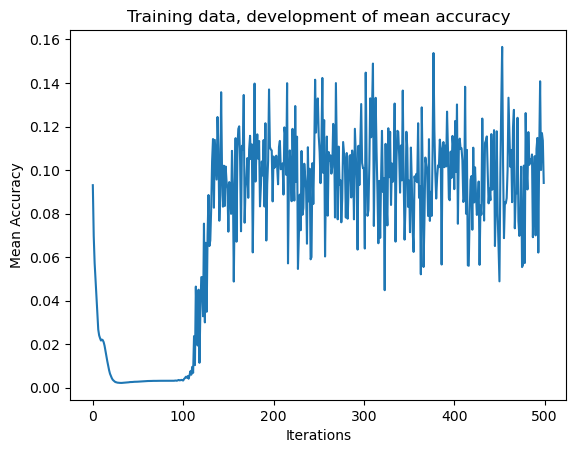

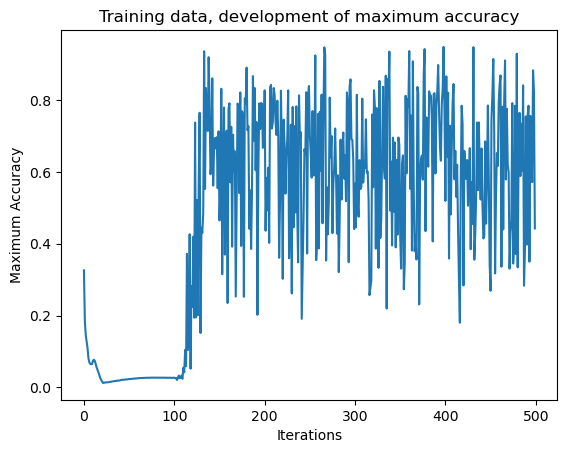

In [8]:
mean_acc = score.groupby("Iteration")["Accuracy"].mean()
x = np.arange(500)
y = mean_acc
plt.plot(x, y)
plt.xlabel("Iterations")
plt.ylabel("Mean Accuracy")
plt.title("Training data, development of mean accuracy")
plt.show()

max_acc = score.groupby("Iteration")["Accuracy"].max()
x = np.arange(500)
y = max_acc
plt.plot(x, y)
plt.xlabel("Iterations")
plt.ylabel("Maximum Accuracy")
plt.title("Training data, development of maximum accuracy")
plt.show()

In [9]:
print("Performance Scores for the last iteration of the model \n")
score.loc[score["Iteration"] == 499]

Performance Scores for the last iteration of the model 



,Iteration,True Class,TP,FP,TN,FN,Precision,Recall,Accuracy,F1-Score
0,499,0,54,716,53361,5869,0.070130,0.009117,0.009117,0.016136
1,499,1,327,1893,51365,6415,0.147297,0.048502,0.048502,0.072975
2,499,2,0,0,54042,5958,0.000000,0.000000,0.000000,0.000000
3,499,3,988,11249,42620,5143,0.080739,0.161148,0.161148,0.107578
4,499,4,2586,28815,25343,3256,0.082354,0.442657,0.442657,0.138872
5,499,5,0,6,54573,5421,0.000000,0.000000,0.000000,0.000000
6,499,6,707,5726,48356,5211,0.109902,0.119466,0.119466,0.114485
7,499,7,998,5897,47838,5267,0.144743,0.159298,0.159298,0.151672
8,499,8,0,2,54147,5851,0.000000,0.000000,0.000000,0.000000
9,499,9,4,32,54019,5945,0.111111,0.000672,0.000672,0.001337


### Testing Performance

In [ ]:
score_testing, parameter_testing = pred(
    X_test_stand, Y_test, n_iter=1, eta=0.1, params=parameter
)

The training and testing mean accuracy is about the same.
However, one can note that, although the maximum accuracy isn't as good,
its performances are more homogenous compared to the training set.
Precision is also higher on average on the testing set.
False Positive rate are also lower in the testing set, which supports the previous findings.

Although the model seems to respond well to the testing data, its performance are still overall disappointing.
Adjustement of the learninig rate could bring out small benefits.
However, to see significant improvements, adding more depth to the model is required.

In [11]:
print("Score of the model on the testing set: \n")
print(score_testing)
print("Mean Accuracy: ", score_testing["Accuracy"].mean())
print("Maximum Accuracy: ", score_testing["Accuracy"].max())

Score of the model on the testing set: 

   Iteration  True Class   TP    FP    TN    FN  Precision    Recall  \
0          0           0    2    12  9008   978   0.142857  0.002041   
1          0           1    0     5  8860  1135   0.000000  0.000000   
2          0           2    0     1  8967  1032   0.000000  0.000000   
3          0           3   29   434  8556   981   0.062635  0.028713   
4          0           4    0     0  9018   982   0.000000  0.000000   
5          0           5  438  4895  4213   454   0.082130  0.491031   
6          0           6  296  3256  5786   662   0.083333  0.308977   
7          0           7    1     0  8972  1027   1.000000  0.000973   
8          0           8   18    93  8933   956   0.162162  0.018480   
9          0           9   67   453  8538   942   0.128846  0.066402   

   Accuracy  F1-Score  
0  0.002041  0.004024  
1  0.000000  0.000000  
2  0.000000  0.000000  
3  0.028713  0.039375  
4  0.000000  0.000000  
5  0.491031  0.140723 